### Pairs Trading - Cointegration

**Motivation:**
- Security A - (Something Correlated to it) is more mean-reverting. Similar securties should trade similarily. Hence, any discrepancies between the correlated pairs should converge
- When there is a discrepancy, we form a long-short spread trade and bet on the discrepancy converging
- Pairs trading is one of the most popular statistical arbitrage strategies in traditional markets. We want to test the performance of this strategy in the cryptocurrency market, as it is still relatively new and should be fertile grounds for finding market inefficiencies
- We will use cointegration to find similar pairs as it is a robust statistical approach for identifying long-term equilibrium relationships between assetsfrom datetime import datetime

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from joblib import Parallel, delayed
from itertools import combinations
from IPython.display import display, Javascript

### Step 0: Data
We selected the top 1,000 currencies sorted by volume from CoinGecko. Then, we filtered out coins with fewer than 90% of daily price data points between 2018 and 2024.

In [2]:
from_pickle = pd.read_pickle('Data/CoinGecko_px_vol_1D.pkl')

In [3]:
price_columns = [col for col in from_pickle.columns if 'price' in col]
crypto_px = from_pickle[price_columns]
crypto_px.columns = crypto_px.columns.droplevel(1)

In [4]:
crypto_px = crypto_px.loc['2018-01-01':]
crypto_px = crypto_px.drop(columns=['TUSD', 'DAI', 'WBTC', 'WETH', 'USDC', 'BSV'])

In [5]:
# Calculate the total number of data points
total_data_points = len(crypto_px)

# Calculate the number of non-NA/null entries for each coin
non_null_counts = crypto_px.notnull().sum()

# Calculate the threshold for 90% of the data points
threshold = 0.90 * total_data_points

# Filter out columns with fewer than 90% of data points
crypto_px = crypto_px.loc[:, non_null_counts >= threshold]

crypto_px

,BTC,XRP,BNB,DOGE,ADA,TRX,LTC,LINK,BCH,EOS,...,UTK,PIVX,SYS,REQ,FUN,VIB,NULS,IDEX,MDT,BORG
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14093.606831,2.310120,8.828099,0.009091,0.747140,0.051654,230.462120,0.751033,2426.970077,7.672278,...,0.467207,10.689500,0.783623,0.867352,0.086325,0.455327,2.267259,NaN,NaN,NaN
2018-01-02,15321.932852,2.455290,9.090393,0.009335,0.807430,0.080893,255.048185,0.689388,2627.026940,9.504036,...,0.647065,11.555000,0.817777,0.809224,0.088933,0.464458,2.510494,NaN,NaN,NaN
2018-01-03,15583.885538,3.125710,9.886323,0.009592,1.075401,0.098107,248.042194,0.704623,2630.511811,10.090184,...,0.896774,10.923600,0.798803,0.795348,0.106564,0.584170,3.696732,NaN,NaN,NaN
2018-01-04,15976.365194,3.220050,9.675758,0.010098,1.179347,0.218139,244.834372,1.036826,2458.894372,11.713284,...,0.874131,10.581200,0.784280,0.826834,0.178514,0.698240,4.788923,NaN,NaN,NaN
2018-01-05,18336.922980,2.931380,16.488523,0.013841,1.077821,0.231673,254.138525,0.996575,2551.321685,9.673192,...,0.762206,9.951170,0.748309,0.761799,0.161191,0.585847,5.659994,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,58804.234500,0.552884,503.472306,0.100570,0.328140,0.127716,59.691360,10.012537,330.440521,0.467477,...,0.038229,0.193892,0.073564,0.090949,0.003115,0.057157,0.245821,0.032078,0.036722,0.170774
2024-08-13,59350.074333,0.568612,518.752217,0.107647,0.338874,0.126661,61.414267,10.561648,354.155288,0.500104,...,0.039951,0.204125,0.078151,0.094758,0.003233,0.058272,0.255234,0.033471,0.038736,0.168182
2024-08-14,60601.223178,0.576440,523.553455,0.106469,0.340317,0.128873,63.411783,10.577495,352.234629,0.507208,...,0.039211,0.203198,0.076065,0.094747,0.003273,0.058356,0.251570,0.033162,0.038288,0.171173


We have 86 coins and will select pairs from among them.

In [6]:
coins_ret = crypto_px / crypto_px.shift() - 1

In [7]:
end_of_insample = pd.Timestamp('2021-12-31')
in_sample_px = crypto_px.loc[:end_of_insample]
in_sample_ret = coins_ret.loc[:end_of_insample]

In [8]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [9]:
def compute_sharpe_ratio(rets):
    mean_rets = rets.mean()*252
    vol = rets.std()*np.sqrt(252)
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio

In [10]:
def compute_stats(rets):
    stats={}
    stats['avg'] = rets.mean()*252
    stats['vol'] = rets.std()*np.sqrt(252)
    stats['sharpe'] = stats['avg']/stats['vol']
    stats['hit_rate'] = rets[rets>0].count() / rets.count()
    stats = pd.DataFrame(stats)
    return stats

In [11]:
def drawdown(px):
    return (px / (px.expanding(min_periods=1).max()) - 1)

In [12]:
def duration(px):
    peak = px.expanding(min_periods=1).max()
    res = pd.DataFrame(index=px.index,columns=px.columns)
    for col in px.columns:
        for dt in px.index:
            if px.loc[dt,col] >= peak.loc[dt,col]:
                 res.loc[dt,col] = 0
            else: 
                res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1
    return res

In [13]:
def plot_with_signals(log_px_i, log_px_j, z_score, exit_threshold=0.5):
    # Define entry signals (when z_score crosses ±1)
    buy_signals_i = (z_score < -1)
    sell_signals_i = (z_score > 1)
    buy_signals_j = (z_score > 1)
    sell_signals_j = (z_score < -1)

    # Define exit signals (when z_score moves back within exit_threshold)
    exit_signals_i = (z_score > -exit_threshold) & (z_score < exit_threshold)
    exit_signals_j = (z_score > -exit_threshold) & (z_score < exit_threshold)

    plt.figure(figsize=(14, 8))

    # Plot log prices
    plt.plot(log_px_i.index, log_px_i, label='Log Price of Asset i', color='blue', linewidth=1.5)
    plt.plot(log_px_j.index, log_px_j, label='Log Price of Asset j', color='orange', linewidth=1.5)

    # Plot z-score
    plt.plot(z_score.index, z_score, label='Z-score', color='grey', linestyle='--', linewidth=1.2)

    # Plot buy and sell signals for asset i
    plt.plot(log_px_i.index[buy_signals_i], log_px_i[buy_signals_i], '^', color='green', label='Buy Signal for Asset i', markersize=4, linestyle='None')
    plt.plot(log_px_i.index[sell_signals_i], log_px_i[sell_signals_i], 'v', color='red', label='Sell Signal for Asset i', markersize=4, linestyle='None')

    # Plot buy and sell signals for asset j
    plt.plot(log_px_j.index[buy_signals_j], log_px_j[buy_signals_j], '^', color='green', label='Buy Signal for Asset j', markersize=4, linestyle='None')
    plt.plot(log_px_j.index[sell_signals_j], log_px_j[sell_signals_j], 'v', color='red', label='Sell Signal for Asset j', markersize=4, linestyle='None')
        
    # Add labels and legend
    plt.title('Log Prices and Z-score with Entry and Exit Signals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Step 1: K-Means Clustering

Before applying the ADF cointegration test, we use K-Means clustering to group assets based on their price movements. The motivation for this step is to improve the accuracy of pairs selection by focusing on similar pairs within each cluster, which can lead to more meaningful and stable cointegration results.

The K-Means clustering algorithm is a widely-used method for partitioning data into clusters. A critical aspect of this algorithm is determining the optimal number of clusters, which can be achieved using the elbow method with cross-validation. The elbow method evaluates the following three loss metrics (or scores) to identify the optimal number of clusters:

- **Distortion Score:** Computes the sum of squared distances from each point to its assigned cluster center. A lower distortion score indicates better clustering.
  
- **Silhouette Score:** Calculates the mean Silhouette Coefficient for all samples, where a higher score indicates better-defined clusters. However, in some contexts, a smaller score might be desirable if it better reflects the underlying data structure.
  
- **Calinski-Harabasz Score:** Measures the ratio of dispersion between clusters to the dispersion within clusters. A higher Calinski-Harabasz score indicates more distinct clustering.

In [14]:
# df_ret = pd.DataFrame()
# df_ret['returns'] = in_sample_ret.mean() * 252
# df_ret['volatility'] = in_sample_ret.std() * 252
# df_ret

df_ret = in_sample_ret.T
df_ret = df_ret.fillna(0)

df_ret

Date,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,...,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-26,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
BTC,0.0,0.087155,0.017097,0.025185,0.147753,0.000368,-0.071076,-0.066873,-0.018593,-0.006117,...,0.043046,-0.007922,0.043989,-0.000234,-0.004426,0.003738,-0.001549,-0.060049,-0.025524,0.014726
XRP,0.0,0.062841,0.273051,0.030182,-0.089648,0.054667,0.099242,-0.279524,-0.125481,-0.086454,...,0.071601,0.007977,0.039717,-0.082694,0.015380,-0.006448,0.006810,-0.075624,-0.044503,0.025235
BNB,0.0,0.029711,0.087557,-0.021299,0.704107,0.477992,-0.206291,-0.006692,-0.012197,-0.047669,...,0.006473,0.008852,0.028293,-0.012964,0.011142,-0.002312,0.031419,-0.050476,-0.041011,0.008139
DOGE,0.0,0.026867,0.027480,0.052787,0.370647,0.146249,0.108449,-0.109243,-0.091217,-0.058875,...,0.021499,0.010355,0.058034,0.021704,0.022989,-0.008596,-0.012783,-0.071295,-0.037974,0.020010
ADA,0.0,0.080694,0.331881,0.096658,-0.086086,0.014807,-0.037417,-0.105384,-0.080368,-0.057446,...,0.029067,0.038522,0.109588,-0.054694,0.043780,-0.000608,0.043578,-0.072124,-0.052310,0.015181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIB,0.0,0.020054,0.257745,0.195269,-0.160966,0.054839,0.115930,-0.123789,0.211784,-0.152078,...,0.072866,-0.010717,0.037804,-0.031996,0.023852,0.030325,-0.003785,-0.090452,-0.025229,0.014593
NULS,0.0,0.107282,0.472512,0.295448,0.181893,0.134467,0.183830,-0.030915,0.107029,0.046217,...,0.015339,-0.039074,0.039445,-0.039225,0.014077,0.009557,-0.006397,-0.082569,0.007490,-0.000615
IDEX,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016365,0.010087,0.064528,-0.037713,0.032267,0.003378,-0.000107,-0.074427,0.001816,0.017243
MDT,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.047286,-0.068624,0.039100,0.320991,0.191634,-0.096932,-0.089626,0.096122,-0.049181,-0.040354


In [15]:
rescaled_data = preprocessing.StandardScaler().fit_transform(df_ret)
train_data = pd.DataFrame(rescaled_data, columns = df_ret.columns, index = df_ret.index)
train_data.head(5)

Date,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,...,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-26,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
BTC,0.0,0.176081,-0.440259,-0.276043,0.826710,-0.609735,-1.036373,-0.443461,-0.388454,0.374106,...,0.018171,-0.613185,-0.380967,0.267198,-0.656021,-0.170409,-0.351430,0.001300,0.108519,-0.103870
XRP,0.0,-0.027190,0.824359,-0.251459,-0.623597,-0.215588,0.845866,-2.415580,-0.976347,-0.407589,...,0.573577,-0.274357,-0.493800,-1.402522,-0.127402,-0.542005,-0.118139,-0.204987,-0.267595,0.182262
BNB,0.0,-0.304162,-0.092128,-0.504725,4.225534,2.857217,-2.530684,0.114652,-0.353271,-0.030208,...,-0.693206,-0.255709,-0.795491,0.009413,-0.240520,-0.391092,0.568677,0.128093,-0.198384,-0.283226
DOGE,0.0,-0.327938,-0.388957,-0.140249,2.188392,0.449179,0.947616,-0.836400,-0.787894,-0.139239,...,-0.400935,-0.223673,-0.010039,0.711413,0.075693,-0.620349,-0.664948,-0.147647,-0.138213,0.040012
ADA,0.0,0.122067,1.115025,0.075577,-0.601841,-0.504924,-0.664405,-0.800608,-0.728220,-0.125337,...,-0.253736,0.376595,1.351536,-0.835553,0.630606,-0.328951,0.908003,-0.158637,-0.422306,-0.091490


In [16]:
# Determine the value for K
class Get_K(object):
    def __init__(self, start, stop, X):
        self.start = start
        self.stop = stop
        self.X = X
        return 
    
    def get_k_distortion(self):
        # Iterate through different values of K        
        Range = range(self.start, self.stop)
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=Range)
        visualizer.fit(self.X)  # Fit the data to the visualizer
        visualizer.show()
        optimal_k = visualizer.elbow_value_
        return optimal_k
    
    def get_k_silhouette(self):
        # Iterate through different values of K        
        if self.start == 1:
            self.start += 1
        Range = range(self.start, self.stop)
        model = KMeans()
        # Use silhouette score
        visualizer2 = KElbowVisualizer(model, k=Range, metric='silhouette')
        visualizer2.fit(self.X)  # Fit the data to the visualizer
        visualizer2.show()  # Finalize and render the figure
        return
    
    def get_k_calinski_harabasz(self):
        # Iterate through different values of K        
        Range = range(self.start, self.stop)
        model = KMeans()
        # Use Calinski-Harabasz score
        visualizer2 = KElbowVisualizer(model, k=Range, metric='calinski_harabasz')
        visualizer2.fit(self.X)  # Fit the data to the visualizer
        visualizer2.show()  # Finalize and render the figure
        return

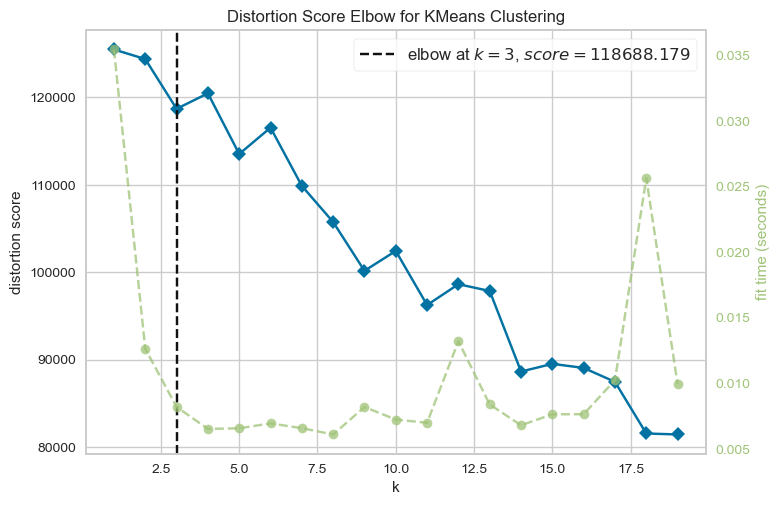

In [17]:
Find_K=Get_K(1, 20, train_data)

# Calling get_k method on our Find_K object
optimal_clusters = Find_K.get_k_distortion()

In [18]:
# Initialize and fit the KMeans model without the deprecated parameters
model = KMeans(n_clusters=optimal_clusters)

# Fit the model and predict the cluster indices
cluster_idx = model.fit_predict(train_data)

In [19]:
# # Create a dataframe with coins and the clusters they belong to
# details = [(name, cluster) for name, cluster in zip(df_ret.index, cluster_idx)]
# details_df = pd.DataFrame(details, columns=['Coins', 'Cluster'])

# # Create another dataframe with the coins and data from each coins
# clusters_df = df_ret.reset_index()

# # Bring the clusters information from the dataframe 'details_df'
# clusters_df['Cluster'] = details_df['Cluster']

# clusters_df.columns = ['Coins', 'Returns', 'Volatility', 'Cluster']

# clusters_df.head(5)

In [20]:
# # Plot the clusters created using Plotly
# fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Coins"])
# fig.update(layout_coloraxis_showscale=False)
# fig.show()

In [21]:
clustered = model.labels_
clustered_series = pd.Series(index = train_data.index, data = clustered.flatten())
clustered_series_all = pd.Series(index = train_data.index, data = clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

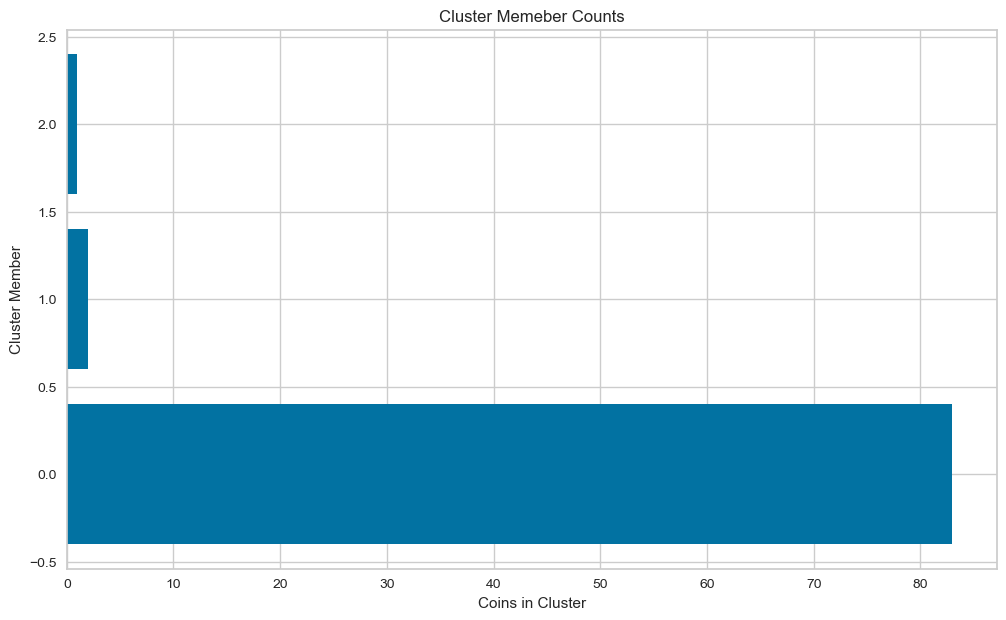

In [22]:
plt.figure(figsize = (12, 7))
plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Cluster Memeber Counts")
plt.xlabel('Coins in Cluster')
plt.ylabel("Cluster Member")
plt.show()

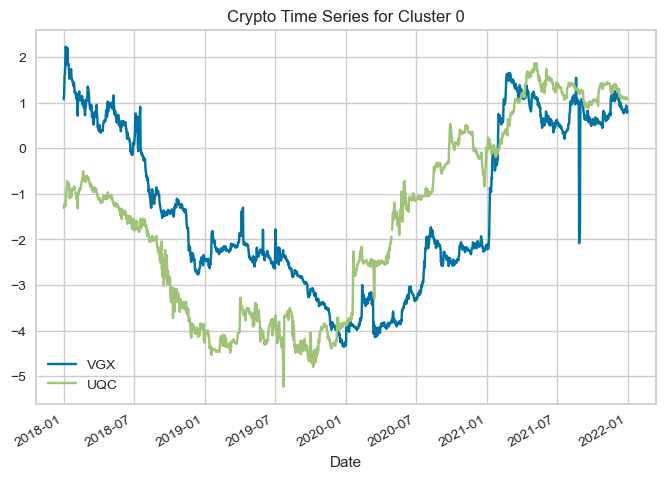

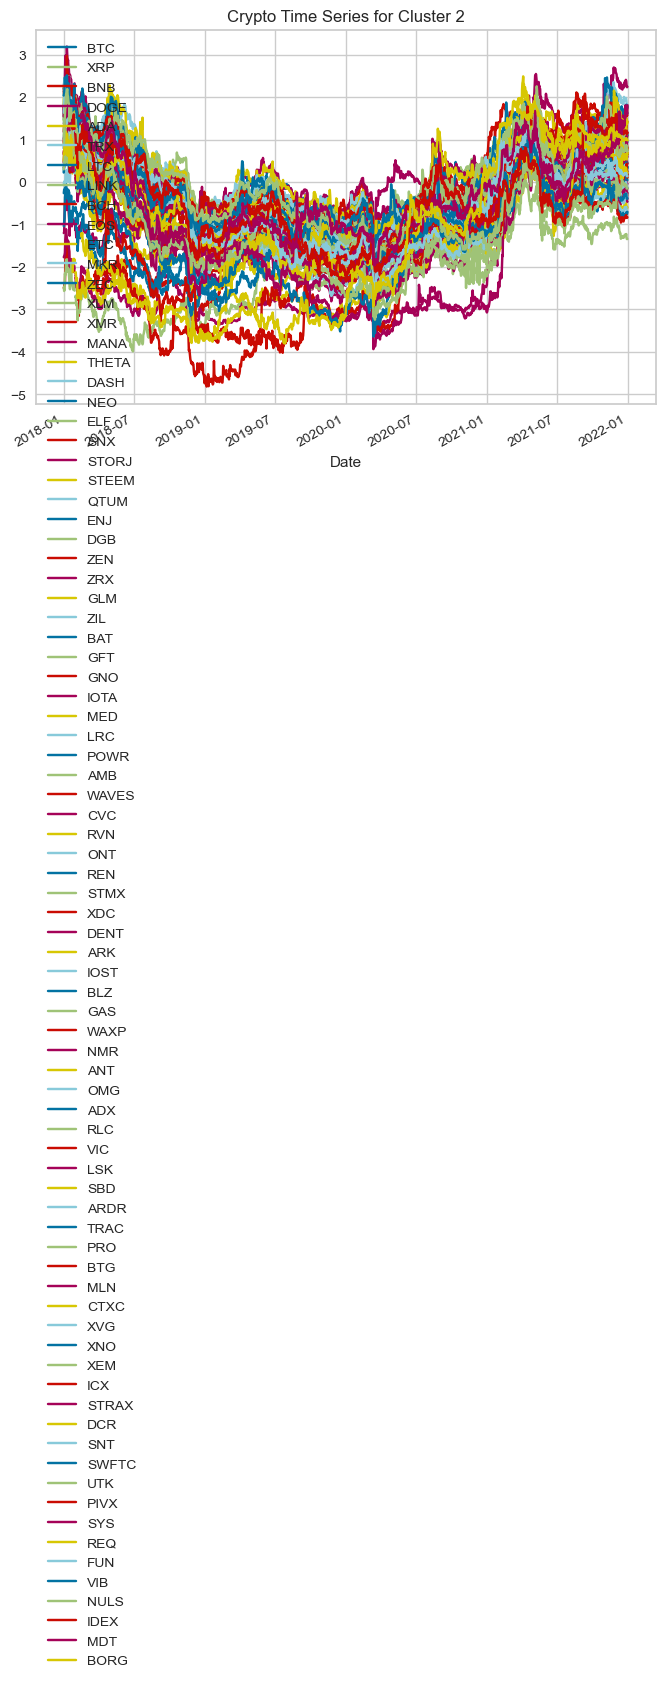

In [23]:
counts = clustered_series.value_counts()
clusters_viz_list = list(counts[(counts < 100) & (counts > 1)].index)[::-1]

in_sample_px = crypto_px[:end_of_insample]

for c in clusters_viz_list:
    coins = list(clustered_series[clustered_series==c].index)
    means = np.log(in_sample_px[coins].mean())
    data = np.log(in_sample_px[coins]).sub(means)
    data.plot(title='Crypto Time Series for Cluster %d' % c)
    plt.show()

### Step 2: Pairs Selection

The formation period is from January 1, 2018, to December 31, 2021. We use daily in-sample frequency to select pairs through the following steps:

1. **OLS Regression:** Perform Ordinary Least Squares (OLS) regression on the log prices of two securities to obtain the residuals:
   $$
   \log(p_{i,t}) = \alpha + \beta \log(p_{j,t}) + \epsilon_t
   $$

2. **Stationarity Test:** Apply the Augmented Dickey-Fuller (ADF) test to the residuals to check for stationarity. A p-value < 0.05 suggests that the residuals are stationary.

3. **Selection Criteria:** For each cluster obtained from K-Means clustering, select the top 50 pairs with the most negative ADF test statistic, ensuring all selected pairs have p-values less than 0.05.

In [24]:
def adf_for_pair(symbol_i, symbol_j, in_sample_px):
    """
    Perform the ADF test on the residuals of the OLS regression between two assets.

    Parameters:
    symbol_i (str): The first asset's symbol.
    symbol_j (str): The second asset's symbol.
    in_sample_px (DataFrame): The DataFrame containing in-sample price data for the assets.

    Returns:
    tuple: A tuple containing the pair (symbol_i, symbol_j) and a tuple of (p_value, test_statistic).
    """
    # Convert raw price to log price
    in_sample_log_px = np.log(in_sample_px)
    
    # Handle missing data
    X = in_sample_log_px[symbol_i].fillna(0).values
    Y = in_sample_log_px[symbol_j].fillna(0).values

    # OLS regression
    model = sm.OLS(Y, sm.add_constant(X)).fit()
    alpha = model.params[0]
    beta = model.params[1]
    residuals = Y - beta * X - alpha

    # ADF test on residuals
    adf_result = adfuller(residuals)
    p_value = adf_result[1]
    test_statistic = adf_result[0]
    
    return (symbol_i, symbol_j), (p_value, test_statistic)

In [25]:
def cointegration(clustered_series, in_sample_px, n_jobs=-1):
    cluster_adf_results = {}

    # Iterate through each unique cluster
    for cluster in clustered_series.unique():
        symbols_in_cluster = clustered_series[clustered_series == cluster].index.tolist()

        if len(symbols_in_cluster) < 2:
            continue

        pairs = [(symbol_i, symbol_j) for i, symbol_i in enumerate(symbols_in_cluster) for j, symbol_j in enumerate(symbols_in_cluster) if i < j]

        # Parallel computation
        adf_results = Parallel(n_jobs=n_jobs)(
            delayed(adf_for_pair)(symbol_i, symbol_j, in_sample_px) for symbol_i, symbol_j in pairs
        )

        # Create a DataFrame for the ADF results of this cluster
        pairs, results = zip(*adf_results)
        adf_df = pd.DataFrame(results, columns=['p_value', 'test_statistic'], index=pairs)
        adf_df = adf_df.sort_values(by='test_statistic')
        cluster_adf_results[cluster] = adf_df

    return cluster_adf_results

In [26]:
def pair_selection(cluster_adf_results, significance_level=0.05):
    """
    Select pairs with p-values less than the given significance level, indicating cointegration.
    
    Parameters:
    cluster_adf_results (dict): A dictionary where the keys are cluster labels and the values are DataFrames 
                                containing ADF test results for pairs within each cluster.
    significance_level (float): The significance level threshold for p-values to select cointegrated pairs.
    
    Returns:
    dict: A dictionary where the keys are cluster labels and the values are DataFrames 
          containing only the pairs with p-values below the significance level.
    """
    selected_pairs = {}

    # Iterate through the clusters
    for cluster, adf_df in cluster_adf_results.items():
        # Filter pairs with p-values less than the significance level
        filtered_df = adf_df[adf_df['p_value'] < significance_level]
        
        # Store the filtered results
        selected_pairs[cluster] = filtered_df

    return selected_pairs

In [27]:
cluster_adf_results = cointegration(clustered_series, in_sample_px)
selected_cointegrated_pairs = pair_selection(cluster_adf_results, significance_level=0.05)

for cluster, df in selected_cointegrated_pairs.items():
    print(f"Cluster {cluster}:")
    print(df)

Cluster 2:
                 p_value  test_statistic
STMX  ARDR  6.265094e-09       -6.614248
      IOST  1.745421e-07       -5.991039
TRX   ARDR  3.525891e-07       -5.854503
STEEM CTXC  3.811222e-07       -5.839269
ONT   NULS  1.392020e-06       -5.581681
...                  ...             ...
DOGE  SYS   4.961125e-02       -2.864687
MKR   MDT   4.976347e-02       -2.863473
LTC   QTUM  4.987223e-02       -2.862607
BAT   ARDR  4.994017e-02       -2.862068
BCH   NULS  4.997600e-02       -2.861783

[1264 rows x 2 columns]
Cluster 0:
Empty DataFrame
Columns: [p_value, test_statistic]
Index: []


In [28]:
def select_top_n_pairs(selected_cointegrated_pairs, n=50):
    """
    Select the top n pairs from each cluster based on the most negative test_statistic.
    
    Parameters:
    selected_cointegrated_pairs (dict): A dictionary where the keys are cluster labels and 
                                        the values are DataFrames containing ADF test results.
    n (int): The number of top pairs to select from each cluster.
    
    Returns:
    dict: A dictionary where the keys are cluster labels and the values are lists of selected top n pairs.
    """
    top_n_pairs = {}

    for cluster, df in selected_cointegrated_pairs.items():
        # Select the top n pairs by sorting by test_statistic (most negative at the top)
        top_pairs = df.sort_values(by='test_statistic').head(n).index.tolist()
        top_n_pairs[cluster] = top_pairs

    return top_n_pairs

In [29]:
# Assume selected_cointegrated_pairs contains ADF test results for each cluster
top_pairs_per_cluster = select_top_n_pairs(selected_cointegrated_pairs, n=50)

# Print the top pairs for each cluster
for cluster, pairs in top_pairs_per_cluster.items():
    print(f"Top pairs for Cluster {cluster} ({len(pairs)} pairs):")
    print(pairs)

Top pairs for Cluster 2 (50 pairs):
[('STMX', 'ARDR'), ('STMX', 'IOST'), ('TRX', 'ARDR'), ('STEEM', 'CTXC'), ('ONT', 'NULS'), ('BTC', 'SWFTC'), ('ELF', 'STEEM'), ('TRX', 'MDT'), ('TRX', 'IOST'), ('XLM', 'ZIL'), ('VIC', 'SBD'), ('ONT', 'LSK'), ('MKR', 'SWFTC'), ('TRX', 'WAXP'), ('XRP', 'CVC'), ('POWR', 'STMX'), ('DGB', 'ZIL'), ('DGB', 'SNT'), ('CTXC', 'STRAX'), ('IOST', 'XVG'), ('GFT', 'CTXC'), ('XLM', 'ADX'), ('POWR', 'REQ'), ('ONT', 'GAS'), ('TRX', 'RVN'), ('XVG', 'FUN'), ('ONT', 'PIVX'), ('MANA', 'STORJ'), ('ZRX', 'IOTA'), ('LRC', 'TRAC'), ('ADA', 'SBD'), ('IOST', 'FUN'), ('ONT', 'STRAX'), ('BLZ', 'STRAX'), ('GLM', 'ICX'), ('MANA', 'XNO'), ('MANA', 'QTUM'), ('ZRX', 'GLM'), ('XMR', 'SWFTC'), ('THETA', 'SBD'), ('GLM', 'IOTA'), ('BNB', 'NEO'), ('XRP', 'GLM'), ('XRP', 'MANA'), ('ARK', 'STRAX'), ('GLM', 'STRAX'), ('BCH', 'SWFTC'), ('TRX', 'ZIL'), ('IOTA', 'ARK'), ('BNB', 'GNO')]
Top pairs for Cluster 0 (0 pairs):
[]


In [30]:
# Input the clusters you want to trade, separated by commas
clusters_to_trade = input("Enter the clusters you want to trade, separated by commas (e.g., 0,1,2,4): ")

# Run all cells below the current one
display(Javascript('IPython.notebook.execute_cells_below()'))

# Convert the input into a list of integers
clusters_to_trade = list(map(int, clusters_to_trade.split(',')))

# Create the final list of pairs by including only the specified clusters
final_pairs = [
    pair for cluster, pairs in top_pairs_per_cluster.items() 
    if cluster in clusters_to_trade 
    for pair in pairs
]

# Now final_pairs will include pairs only from the clusters you specified
print(f"Selected pairs: {final_pairs}")
print(f"Total number of pairs: {len(final_pairs)}")

Enter the clusters you want to trade, separated by commas (e.g., 0,1,2,4): 2


<IPython.core.display.Javascript object>

Selected pairs: [('STMX', 'ARDR'), ('STMX', 'IOST'), ('TRX', 'ARDR'), ('STEEM', 'CTXC'), ('ONT', 'NULS'), ('BTC', 'SWFTC'), ('ELF', 'STEEM'), ('TRX', 'MDT'), ('TRX', 'IOST'), ('XLM', 'ZIL'), ('VIC', 'SBD'), ('ONT', 'LSK'), ('MKR', 'SWFTC'), ('TRX', 'WAXP'), ('XRP', 'CVC'), ('POWR', 'STMX'), ('DGB', 'ZIL'), ('DGB', 'SNT'), ('CTXC', 'STRAX'), ('IOST', 'XVG'), ('GFT', 'CTXC'), ('XLM', 'ADX'), ('POWR', 'REQ'), ('ONT', 'GAS'), ('TRX', 'RVN'), ('XVG', 'FUN'), ('ONT', 'PIVX'), ('MANA', 'STORJ'), ('ZRX', 'IOTA'), ('LRC', 'TRAC'), ('ADA', 'SBD'), ('IOST', 'FUN'), ('ONT', 'STRAX'), ('BLZ', 'STRAX'), ('GLM', 'ICX'), ('MANA', 'XNO'), ('MANA', 'QTUM'), ('ZRX', 'GLM'), ('XMR', 'SWFTC'), ('THETA', 'SBD'), ('GLM', 'IOTA'), ('BNB', 'NEO'), ('XRP', 'GLM'), ('XRP', 'MANA'), ('ARK', 'STRAX'), ('GLM', 'STRAX'), ('BCH', 'SWFTC'), ('TRX', 'ZIL'), ('IOTA', 'ARK'), ('BNB', 'GNO')]
Total number of pairs: 50


### Step 3: Trading Strategy

For the backtesting period from January 1, 2022, to the present, we implement the following strategy to each selected pairs:

#### 1. Signal Generation

- **Residual Calculation:**

  $$
  \epsilon_t = \log(p_{i,t}) - (\beta_t \log(p_{j,t}) + \alpha_t)
  $$

  where:
  - $\log(p_{i,t})$ and $\log(p_{j,t})$ are the log prices of coins $i$ and $j$ at time $t$.
  - **$\beta_t$** is calculated as:

   $$
   \beta_t = \text{Corr}_{t} \times \frac{\text{Vol}_{j,t}}{\text{Vol}_{i,t}}
   $$


    with:
    - **$\text{Corr}_{t}$** is the 90-day rolling correlation between $\log(p_{i,t})$ and $\log(p_{j,t})$.
    - **$\text{Vol}_{i,t}$** and **$\text{Vol}_{j,t}$** are the 90-day rolling volatilities of $\log(p_{i,t})$ and $\log(p_{j,t})$, respectively.
  - **$\alpha_t$** is calculated as:

  $$
  \alpha_t = \mu_{\log(p_{j,t})} - \beta_t \cdot \mu_{\log(p_{i,t})}
  $$
  
  where:
  - $\mu_{\log(p_{j,t},90)}$ is the 90-day rolling mean of $\log(p_{j,t})$.
  - $\mu_{\log(p_{i,t},90)}$ is the 90-day rolling mean of $\log(p_{i,t})$.

  
- **Z-Score Calculation:**

  $$
  z_t = \frac{\epsilon_t - \mu_t}{\sigma_t}
  $$

  where:
  - $\mu_t$ is the 90-day rolling mean of the spread.
  - $\sigma_t$ is the 90-day rolling standard deviation of the spread.

#### 2. Portfolio Construction

- **Entry Signals:**
  - **Short** coin $i$ and **long** $\beta_t$ units of coin $j$ if $z_t > 1$.
  - **Long** coin $i$ and **short** $\beta_t$ units of coin $j$ if $z_t < -1$.

- **Exit Signals:**
  - Close the position when $z_t$ moves to any of the following thresholds:

    $$
    z_t \geq -\text{threshold} \quad \text{or} \quad z_t \leq \text{threshold}
    $$

    where threshold is one of the values: 0.1, 0.2, 0.5, or 0.7.

In [31]:
def gen_signals(px, pairs, window=90):
    signal_df = {}
    
    for pair in pairs:
        asset_i, asset_j = pair
        
        # Forward-fill missing values and replace zeros with NaNs
        px_i = px[asset_i].replace(0, np.nan).ffill()
        px_j = px[asset_j].replace(0, np.nan).ffill()
        
        # Apply log transformation
        log_px_i = np.log(px_i)
        log_px_j = np.log(px_j)
        
        # Calculate rolling covariance and variance 
        rolling_cov = log_px_i.rolling(window=window, min_periods=1).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window, min_periods=1).var()
        
        # Calculate beta and alpha
        beta = rolling_cov / rolling_var
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()
        
        # Calculate spread for time t using beta and alpha
        spread = log_px_i - (beta * log_px_j + alpha)
        
        # Calculate rolling mean and standard deviation of the spread using data up to t
        spread_mean = spread.rolling(window=window, min_periods=1).mean()
        spread_std = spread.rolling(window=window, min_periods=1).std()
        
        # Calculate the z-score for time t using spread(t), mean(t), and std(t)
        z_score = (spread - spread_mean) / spread_std
        
        # Store beta, alpha, spread, and z-score in a multi-level column DataFrame
        signal_df[(pair, 'beta')] = beta
        signal_df[(pair, 'alpha')] = alpha
        signal_df[(pair, 'spread')] = spread
        signal_df[(pair, 'z_score')] = z_score
    
    # Convert the dictionary to a DataFrame
    signal_df = pd.DataFrame(signal_df)
    
    return signal_df

In [32]:
def gen_port(signal_df, pairs, threshold=0.5):
    # Initialize a DataFrame with the same index and columns as crypto_px, filled with NaN
    pos = pd.DataFrame(index=signal_df.index, columns=in_sample_px.columns)
    for pair in pairs:
        asset_i, asset_j = pair
        # Access z-scores and betas for this pair
        z_scores = signal_df[(pair, 'z_score')]
        betas = signal_df[(pair, 'beta')]

        # Set positions based on z-scores
        pos.loc[z_scores > 1, asset_i] = -1  # Short one unit of asset_i
        pos.loc[z_scores < -1, asset_i] = 1  # Long one unit of asset_i
        pos.loc[(z_scores.abs() <= threshold), asset_i] = 0  # Exit signal

        pos.loc[z_scores > 1, asset_j] = betas  # Long beta units of asset_j
        pos.loc[z_scores < -1, asset_j] = -betas  # Short beta units of asset_j
        pos.loc[(z_scores.abs() <= threshold), asset_j] = 0  # Exit signal

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalize to ensure a fully-invested portfolio
    pos = pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0)
    return pos

### Step 4: Performance Evaluation

We evaluate the strategy's performance across four exit thresholds: 0.1, 0.2, 0.5, and 0.7. For each threshold, the following key metrics are calculated:

- **Sharpe Ratio**: Risk-adjusted return of the strategy.
- **Transaction Costs**: Average costs incurred due to trading.
- **Holding Period**: Average number of days a position is held.
- **Turnover**: Average daily proportion of the portfolio that is traded.
- **Annualized Return**: Average yearly return of the strategy.
- **Annualized Volatility**: Standard deviation of returns on an annual basis, indicating risk.

Cryptocurrencies can have commissions of ~7bps. While total slippage is unknown and will depend on the trader’s volume as well, let’s assume another 13 bps. So total all-in execution costs will be 20 bps for market-orders.

In [33]:
# Define the thresholds and initialize the arrays for storing metrics
thresholds = [0.1, 0.2, 0.5, 0.7]
metrics = {
    'Sharpe Ratio': np.zeros(len(thresholds)),
    'Return': np.zeros(len(thresholds)),
    'Volatility': np.zeros(len(thresholds)),
    'Holding Period': np.zeros(len(thresholds)),
    'Turnover': np.zeros(len(thresholds)),
    'Transaction Costs': np.zeros(len(thresholds)),
}

# Set the start of the out-of-sample period
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)

# Loop over each threshold to calculate metrics
for i, threshold in enumerate(thresholds):
    # Generate signals
    signal_df = gen_signals(crypto_px, final_pairs, window=90)
    signal_df = signal_df.loc[start_of_out_sample:]
    
    # Generate portfolio
    port = gen_port(signal_df, final_pairs, threshold)
    
    # Calculate out-of-sample daily returns
    out_sample_ret = coins_ret.loc[start_of_out_sample:][port.columns]
    strat_gross_ret = (port.shift() * out_sample_ret).sum(1)
    
    # Calculate net returns
    to = compute_turnover(port)
    tcost_bps = 20  # (commissions + slippage)
    strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)
    
    # Compute Sharpe ratio
    sharpe_ratio = compute_sharpe_ratio(strat_net_ret)
    metrics['Sharpe Ratio'][i] = sharpe_ratio
    
    # Compute transaction costs
    total_tcost = to * tcost_bps * 1e-4
    metrics['Transaction Costs'][i] = total_tcost.sum()
    
    # Compute holding period (average number of days a position is held)
    metrics['Holding Period'][i] = 2/to.mean()
    
    # Store turnover
    metrics['Turnover'][i] = to.mean()
    
    # Compute return 
    returns = strat_net_ret.mean()
    metrics['Return'][i] = returns
    
    # Compute volatility
    volatility = strat_net_ret.std()
    metrics['Volatility'][i] = volatility
    
# Convert metrics to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics, index=thresholds)

# Display the results
print(metrics_df)

     Sharpe Ratio    Return  Volatility  Holding Period  Turnover  \
0.1      0.398520  0.000295    0.011761       16.667477  0.119994   
0.2      0.510106  0.000384    0.011945       14.976917  0.133539   
0.5      0.618778  0.000525    0.013465       12.855915  0.155570   
0.7      0.540905  0.000484    0.014207       11.904376  0.168005   

     Transaction Costs  
0.1           0.230389  
0.2           0.256395  
0.5           0.298695  
0.7           0.322570  


In [34]:
signal_df = gen_signals(crypto_px, final_pairs, window=90)
signal_df = signal_df.loc[start_of_out_sample:]
signal_df.head()

(STMX, ARDR)                               (STMX, IOST)            \
                   beta     alpha    spread   z_score         beta     alpha   
Date                                                                           
2022-01-01     0.976973  2.286002 -4.692476 -0.921972     1.225528  1.200929   
2022-01-02     0.978035  2.289289 -4.678862 -0.894442     1.212983  1.154949   
2022-01-03     0.966184  2.247958 -4.785651 -1.228662     1.205656  1.127229   
2022-01-04     0.959384  2.224171 -4.715912 -1.028174     1.195915  1.091285   
2022-01-05     0.950663  2.192967 -4.690044 -0.966101     1.185268  1.052796   

                               (TRX, ARDR)            ... (TRX, ZIL)  \
              spread   z_score        beta     alpha  ...     spread   
Date                                                  ...              
2022-01-01 -0.818760  0.276807    1.191541  1.615186  ...   0.187815   
2022-01-02 -0.822690  0.234057    1.196097  1.624553  ...   0.165591   
2022-01-03 -0.832666  0.153649    1.169900  1.563528  ...   0.164307   
2022-01-04 -0.801974  0.321391    1.151321  1.519484  ...   0.199569   
2022-01-05 -0.812649  0.236589    1.138245  1.487281  ...   0.233236   

                     (IOTA, ARK)                               (BNB, GNO)  \
             z_score        beta     alpha    spread   z_score       beta   
Date                                                                        
2022-01-01  0.296709    1.260809  0.132260 -0.027921  3.060322   1.068316   
2022-01-02  0.185947    1.220757  0.138089 -0.016111  2.979724   1.038807   
2022-01-03  0.166832    1.207360  0.138316 -0.143087  1.713722   1.004713   
2022-01-04  0.308852    1.188472  0.140468 -0.157426  1.539617   0.966891   
2022-01-05  0.444622    1.190097  0.139387 -0.308419  0.140305   0.926648   

                                          
               alpha    spread   z_score  
Date                                      
2022-01-01 -0.696023  0.227821 -2.753486  
2022-01-02 -0.505697  0.256798 -2.483879  
2022-01-03 -0.286661  0.282390 -2.261169  
2022-01-04 -0.044031  0.264406 -2.308862  
2022-01-05  0.214040  0.206805 -2.566667  

[5 rows x 200 columns]

<Axes: xlabel='Date'>

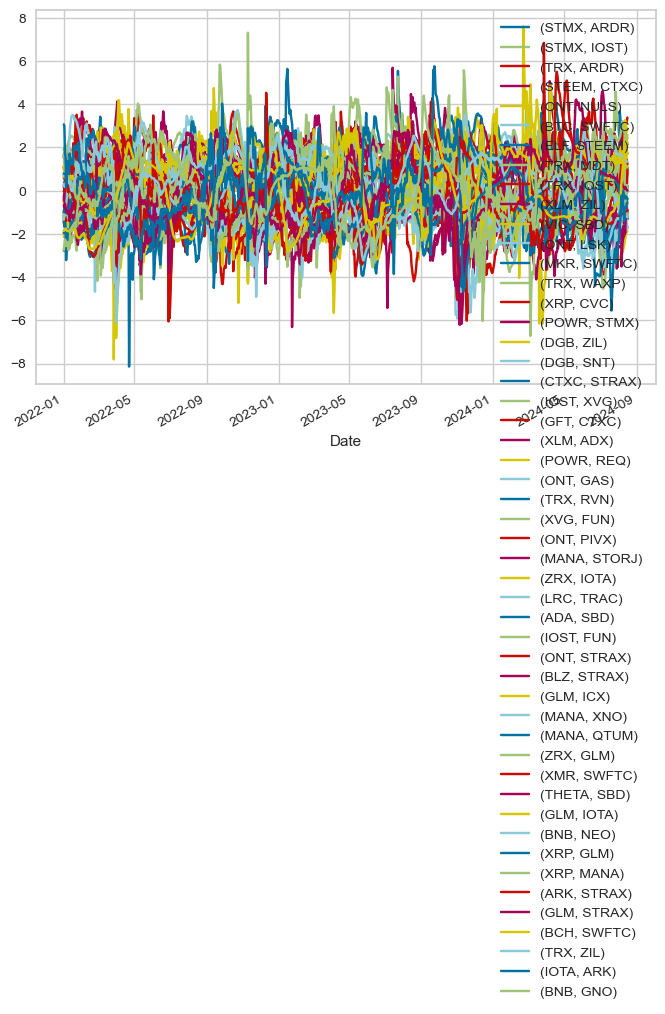

In [35]:
# plot the z-score
z_score_df = signal_df.xs('z_score', axis=1, level=1)
z_score_df.plot()

In [36]:
# portfolio construction
port = gen_port(signal_df, final_pairs, 0.5)
port.head()

,BTC,XRP,BNB,DOGE,ADA,TRX,LTC,LINK,BCH,EOS,...,UTK,PIVX,SYS,REQ,FUN,VIB,NULS,IDEX,MDT,BORG
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-0.032500,-0.032500,0.032500,0.0,0.032500,0.0,0.0,0.0,0.032500,0.0,...,0.0,0.0,0.0,-0.023811,0.033147,0.0,0.034616,0.0,0.000000,0.0
2022-01-02,-0.032216,-0.032216,0.032216,0.0,0.032216,0.0,0.0,0.0,0.032216,0.0,...,0.0,0.0,0.0,-0.023254,0.033076,0.0,0.034089,0.0,0.000000,0.0
2022-01-03,-0.035246,-0.035246,0.035246,0.0,0.035246,0.0,0.0,0.0,0.035246,0.0,...,0.0,0.0,0.0,0.000000,0.036563,0.0,0.037354,0.0,0.000000,0.0
2022-01-04,-0.035910,-0.035910,0.035910,0.0,0.035910,0.0,0.0,0.0,0.035910,0.0,...,0.0,0.0,0.0,0.000000,0.037735,0.0,0.037587,0.0,0.000000,0.0
2022-01-05,-0.034170,-0.034170,0.034170,0.0,0.034170,0.0,0.0,0.0,0.034170,0.0,...,0.0,0.0,0.0,0.000000,0.036381,0.0,0.035130,0.0,0.092935,0.0


<Axes: xlabel='Date'>

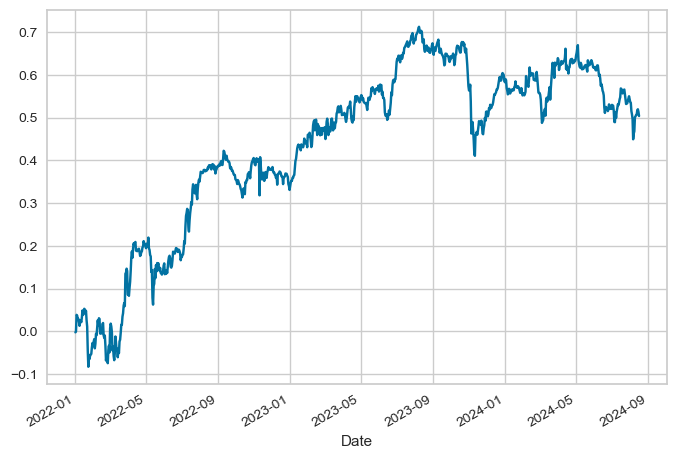

In [37]:
# Calculate out-of-sample daily returns
out_sample_ret = coins_ret.loc[start_of_out_sample:][port.columns]
strat_gross_ret = (port.shift() * out_sample_ret).sum(1)

# Calculate net returns
to = compute_turnover(port)
tcost_bps = 20  # (commissions + slippage)
strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

strat_net_ret.cumsum().plot()

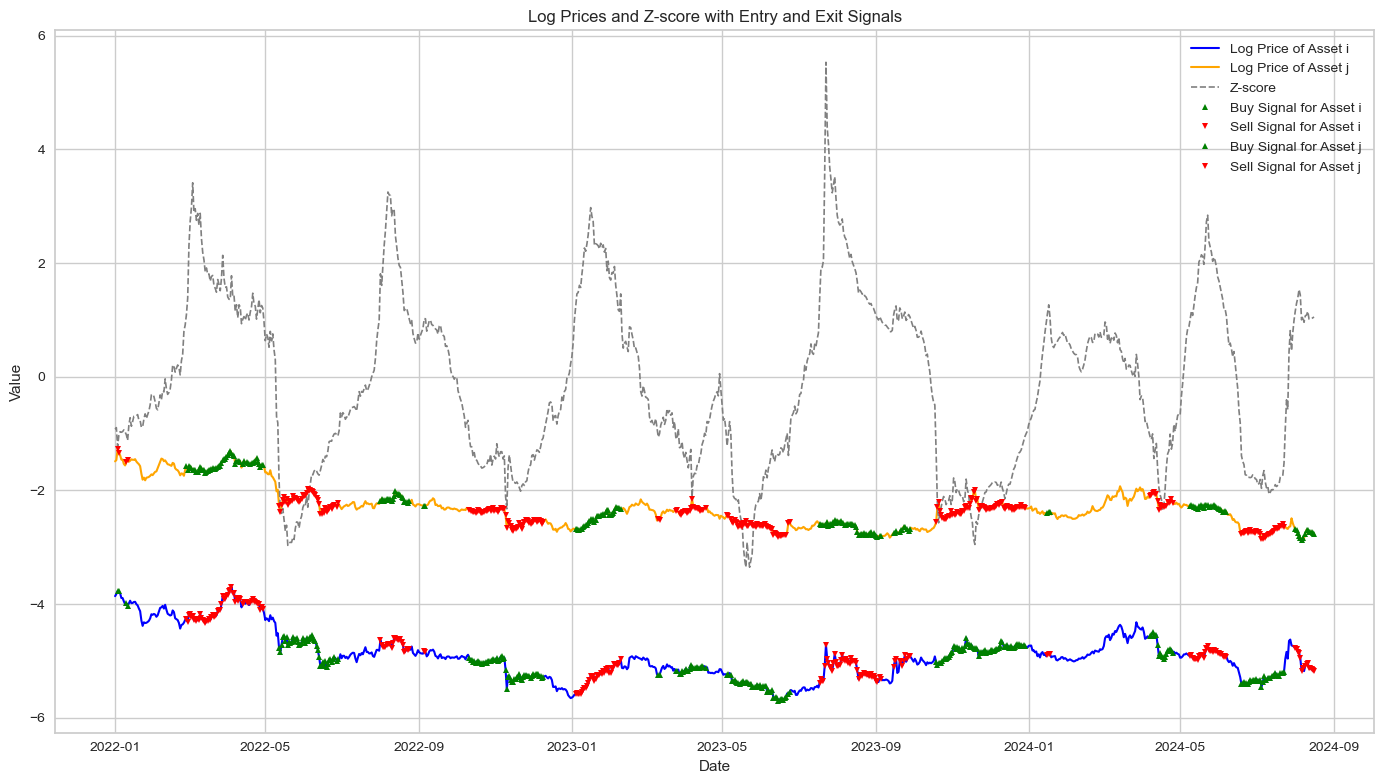

In [38]:
# select a random pair and visualize their log-prices and z-scores 
asset_i, asset_j = final_pairs[0] 
log_px_i = np.log(crypto_px.loc[start_of_out_sample:][asset_i])
log_px_j = np.log(crypto_px.loc[start_of_out_sample:][asset_j])
z_score = signal_df[(final_pairs[0], 'z_score')]

plot_with_signals(log_px_i, log_px_j, z_score)

In [39]:
buy_and_hold_btc = coins_ret['BTC'][start_of_out_sample:]
buy_and_hold_btc

Date
2022-01-01   -0.018482
2022-01-02    0.032307
2022-01-03   -0.008969
2022-01-04   -0.018065
2022-01-05   -0.012747
                ...   
2024-08-12   -0.034218
2024-08-13    0.009282
2024-08-14    0.021081
2024-08-15   -0.030726
2024-08-16   -0.018984
Name: BTC, Length: 960, dtype: float64

In [40]:
full_sample_ret = pd.DataFrame({
    'strat_ret': strat_net_ret,
    'buy_and_hold_btc': buy_and_hold_btc
})

full_sample_stats = compute_stats(full_sample_ret)
print(full_sample_stats)

                       avg       vol    sharpe  hit_rate
strat_ret         0.132263  0.213748  0.618778  0.540625
buy_and_hold_btc  0.160358  0.457895  0.350208  0.493737


<Axes: xlabel='Date'>

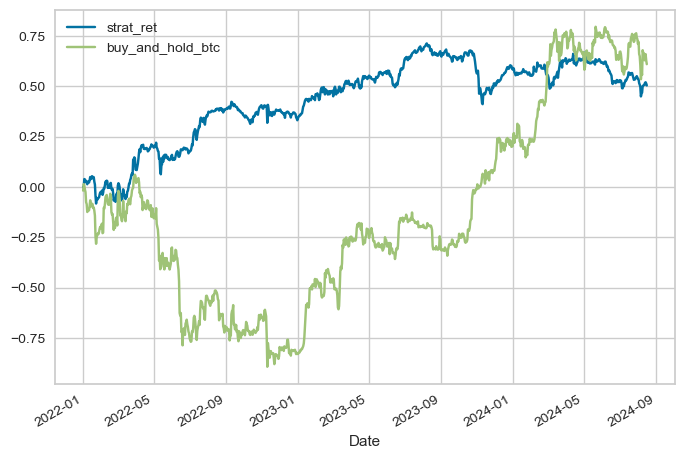

In [41]:
full_sample_ret.cumsum().plot()

In [42]:
corr = full_sample_ret.rolling(252).corr(full_sample_ret['buy_and_hold_btc'])
vol = full_sample_ret.rolling(252).std()

beta = (corr*vol).divide(vol['buy_and_hold_btc'], 0)

# Computing Point-in-Time Residual Returns
resid = full_sample_ret - beta.multiply(full_sample_ret['buy_and_hold_btc'], axis=0)
print(resid)
print(resid.corr())

# The information ratio
IR = resid.mean()/resid.std()*np.sqrt(252)
print(f"Information ratio is {IR['strat_ret']}")

            strat_ret  buy_and_hold_btc
Date                                   
2022-01-01        NaN               NaN
2022-01-02        NaN               NaN
2022-01-03        NaN               NaN
2022-01-04        NaN               NaN
2022-01-05        NaN               NaN
...               ...               ...
2024-08-12   0.004014      0.000000e+00
2024-08-13   0.009411      0.000000e+00
2024-08-14   0.000485      3.469447e-18
2024-08-15  -0.003076      0.000000e+00
2024-08-16  -0.007886      0.000000e+00

[960 rows x 2 columns]
                  strat_ret  buy_and_hold_btc
strat_ret          1.000000         -0.010489
buy_and_hold_btc  -0.010489          1.000000
Information ratio is -0.34552324587845623


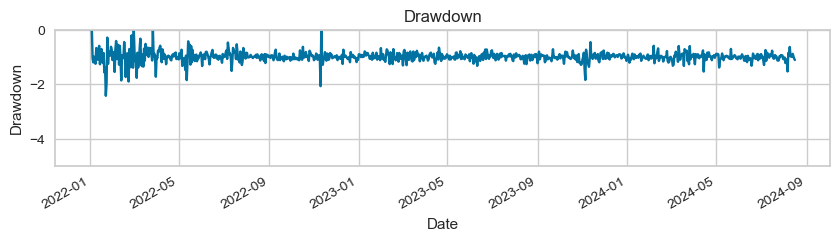

The max drawdown is -2.4262902239499002


In [43]:
# max drawdown
dd = drawdown(full_sample_ret['strat_ret'])
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-5, 0)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()
print(f"The max drawdown is {dd.min()}")

In [44]:
ddd = duration(full_sample_ret.cumsum())
ddd

,strat_ret,buy_and_hold_btc
Date,,
2022-01-01,0,0
2022-01-02,0,0
2022-01-03,0,1
2022-01-04,1,2
2022-01-05,2,3
...,...,...
2024-08-12,370,83
2024-08-13,371,84
2024-08-14,372,85


<Axes: xlabel='Date'>

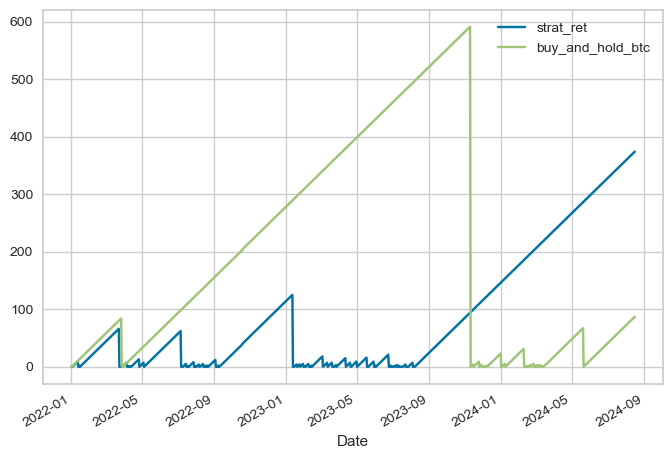

In [45]:
ddd.plot()

In [47]:
# maximum drawdown duration
ddd.max()

strat_ret           374
buy_and_hold_btc    591
dtype: object